# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>
1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

**Write your answer in this cell.**

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [12]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


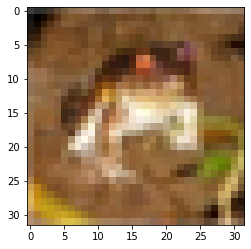

In [13]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-73 and DenseNet-93 with compression and bottleneck as depicted in the original paper. DenseNet-73 and DenseNet-93 follow the architecture of DenseNet and remove several convolution layers for time efficiency. Specifically, DenseNet-73 and DenseNet-93 have a group of 4 Dense Block, each has a set of [4,8,12,10] and [4,8,16,16] mini-block including a 1x1 conv follow by a 3x3 conv. For more details, please refer to Table 1 in the original paper.

In [14]:
# implement the code of your DenseNet-73 model here.
from tensorflow.keras.models import Model,save_model,load_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
def DenseLayer(x, nb_filter, bn_size=4, alpha=0.0, drop_rate=0.2):
    # Bottleneck layers
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(bn_size * nb_filter, (1, 1), strides=(1, 1), padding='same')(x)

    # Composite function
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(nb_filter, (3, 3), strides=(1, 1), padding='same')(x)

    if drop_rate:
        x = Dropout(drop_rate)(x)

    return x


def DenseBlock(x, nb_layers, growth_rate, drop_rate=0.2):
    for ii in range(nb_layers):#nb_layers means the number of denseblock
        conv = DenseLayer(x, nb_filter=growth_rate, drop_rate=drop_rate)
        x = concatenate([x, conv], axis=3)

    return x


def TransitionLayer(x, compression=0.5, alpha=0.0):
    nb_filter = int(x.shape.as_list()[-1] * compression)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(nb_filter, (1, 1), strides=(1, 1), padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)

    return x


growth_rate = 32

inpt = Input(shape=(32, 32, 3))

x = Conv2D(growth_rate * 2, (3, 3), strides=1, padding='same')(inpt)
x = BatchNormalization(axis=3)(x)
x = LeakyReLU(alpha=0.0)(x)

x = DenseBlock(x, 4, growth_rate, drop_rate=0.2)

x = TransitionLayer(x)

x = DenseBlock(x, 8, growth_rate, drop_rate=0.2)

x = TransitionLayer(x)

x = DenseBlock(x, 12, growth_rate, drop_rate=0.2)

x = TransitionLayer(x)

x = DenseBlock(x, 10, growth_rate, drop_rate=0.2)

x = BatchNormalization(axis=3)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(10, activation='softmax')(x)

model = Model(inpt, x)
optimizer=tf.optimizers.Adam(1e-1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 32, 32, 64)   1792        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 32, 32, 64)   256         conv2d_164[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_164 (LeakyReLU)     (None, 32, 32, 64)   0           batch_normalization_166[0][0]    
____________________________________________________________________________________________

In [15]:
# implement the code of your DenseNet-93 model here.
from tensorflow.keras.models import Model,save_model,load_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D

def DenseLayer(x, nb_filter, bn_size=4, alpha=0.0, drop_rate=0.3):
    # Bottleneck layers
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(bn_size * nb_filter, (1, 1), strides=(1, 1), padding='same')(x)

    # Composite function
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(nb_filter, (3, 3), strides=(1, 1), padding='same')(x)
    if drop_rate:
        x = Dropout(drop_rate)(x)


    return x


def DenseBlock(x, nb_layers, growth_rate, drop_rate=0.3):
    for ii in range(nb_layers):#nb_layers means the number of denseblock
        conv = DenseLayer(x, nb_filter=growth_rate, drop_rate=drop_rate)
        x = concatenate([x, conv], axis=3)

    return x


def TransitionLayer(x, compression=0.5, alpha=0.0):
    nb_filter = int(x.shape.as_list()[-1] * compression)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(nb_filter, (1, 1), strides=(1, 1), padding='same')(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)

    return x


growth_rate = 32

inpt = Input(shape=(32, 32, 3))

x = Conv2D(growth_rate * 2, (3, 3), strides=1, padding='same')(inpt)
x = BatchNormalization(axis=3)(x)
x = LeakyReLU(alpha=0.0)(x)

x = DenseBlock(x, 4, growth_rate, drop_rate=0.3)

x = TransitionLayer(x)

x = DenseBlock(x, 8, growth_rate, drop_rate=0.3)

x = TransitionLayer(x)

x = DenseBlock(x, 16, growth_rate, drop_rate=0.3)

x = TransitionLayer(x)

x = DenseBlock(x, 16, growth_rate, drop_rate=0.3)

x = BatchNormalization(axis=3)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(10, activation='softmax')(x)

model_93 = Model(inpt, x)
optimizer=tf.optimizers.Adam(1e-1)
model_93.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_93.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 32, 32, 64)   1792        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 32, 32, 64)   256         conv2d_236[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_236 (LeakyReLU)     (None, 32, 32, 64)   0           batch_normalization_239[0][0]    
____________________________________________________________________________________________

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

In [ ]:
# implement your code here. densenet -73
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
history=model.fit(x_train,y_train,epochs=50,batch_size=64,verbose=1)
save_model(model, 'DenseNet-73')

Epoch 1/50
184/782 [======>.......................] - ETA: 2:46 - loss: 2.8763 - accuracy: 0.2031

In [ ]:
# implement your code here. densenet -93
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
history=model_93.fit(x_train,y_train,epochs=50,batch_size=64,verbose=1)
save_model(model_93, 'DenseNet-93')

### 4.2 Test your models. (5 marks)

In [ ]:
# densenet-73
model_73 = load_model('DenseNet-73')
score = model_73.evaluate(x_test,y_test, verbose=1)
print('Test loss =', score[0])
print('Test accuracy =', score[1])


In [ ]:
# densenet-93
model_93 = load_model('DenseNet-93')
score = model_93.evaluate(x_test,y_test, verbose=1)
print('Test loss =', score[0])
print('Test accuracy =', score[1])

---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

Use the pre-trained DenseNet-121 model from keras and fine-tune them by adding a few fc layers at the end. You should set the parameter weights='imagenet', rather than None, to use the pretrained weights.

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model,save_model,load_model
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
num_classes = 10
inputs = tf.keras.Input(shape=(32, 32, 3))
mydensenet=DenseNet121(weights="imagenet",include_top=False,input_shape=(32,32,3))
x=mydensenet(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax', name='fc')(x)
model=tf.keras.Model(inputs,outputs)
model.summary()
optimizer=tf.optimizers.Adam(1e-1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=50,batch_size=64,verbose=1)
score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss =', score[0])
print('Test accuracy =', score[1])
# implement your code here.

---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-93 better than DenseNet-73? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:

2. Compare the results of your implementations with the pre-trained DenseNet-121 models from Keras. (10 marks)

Answer:

